In [306]:
import sys
import collections
import numpy as np
from scipy.stats import norm

%matplotlib notebook
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value, s_from_r
from higgs_inference import settings


In [105]:
colors     = ['#CC002E',  'c',    'mediumblue', 'darkgreen', 'orange']
linestyles = [  '--',   '-.',    ':',      '-.',          '--',        '-',         '--',  ':']
linewidths = [  1.5,     1.5,    2.,       1.5,            1.5,         1.5,          1.5,  2]

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

def ccolor(theta):
    cmap = matplotlib.cm.get_cmap('viridis')
    return cmap((theta + 1) / 2.)

In [62]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace)

# Toy model

In [360]:
def pdf(x, theta):
    mean = 2. * theta + 4
    sigma = 1. + 0.2 * (theta + 1.)**2
    sigma_noise = 5.
    return norm.pdf(x, mean, sigma)


def log_likelihood(x, theta):
    return np.log(pdf(x,theta))


def score(x, theta):
    epsilon = 1.e-2
    return (log_likelihood(x, theta + epsilon) - log_likelihood(x, theta - epsilon))/ (2.*epsilon)


def samples(n, theta):
    mean = theta + 4.
    sigma = 1. + 0.5 * (theta + 1.)**2
    return np.random.normal(mean, sigma, size=n)


def add_noise(data):
    sigma_noise = 0.2
    return np.exp(np.log(data) + np.random.normal(0., sigma_noise, size=data.shape))
    


# pdf and score 

<IPython.core.display.Javascript object>


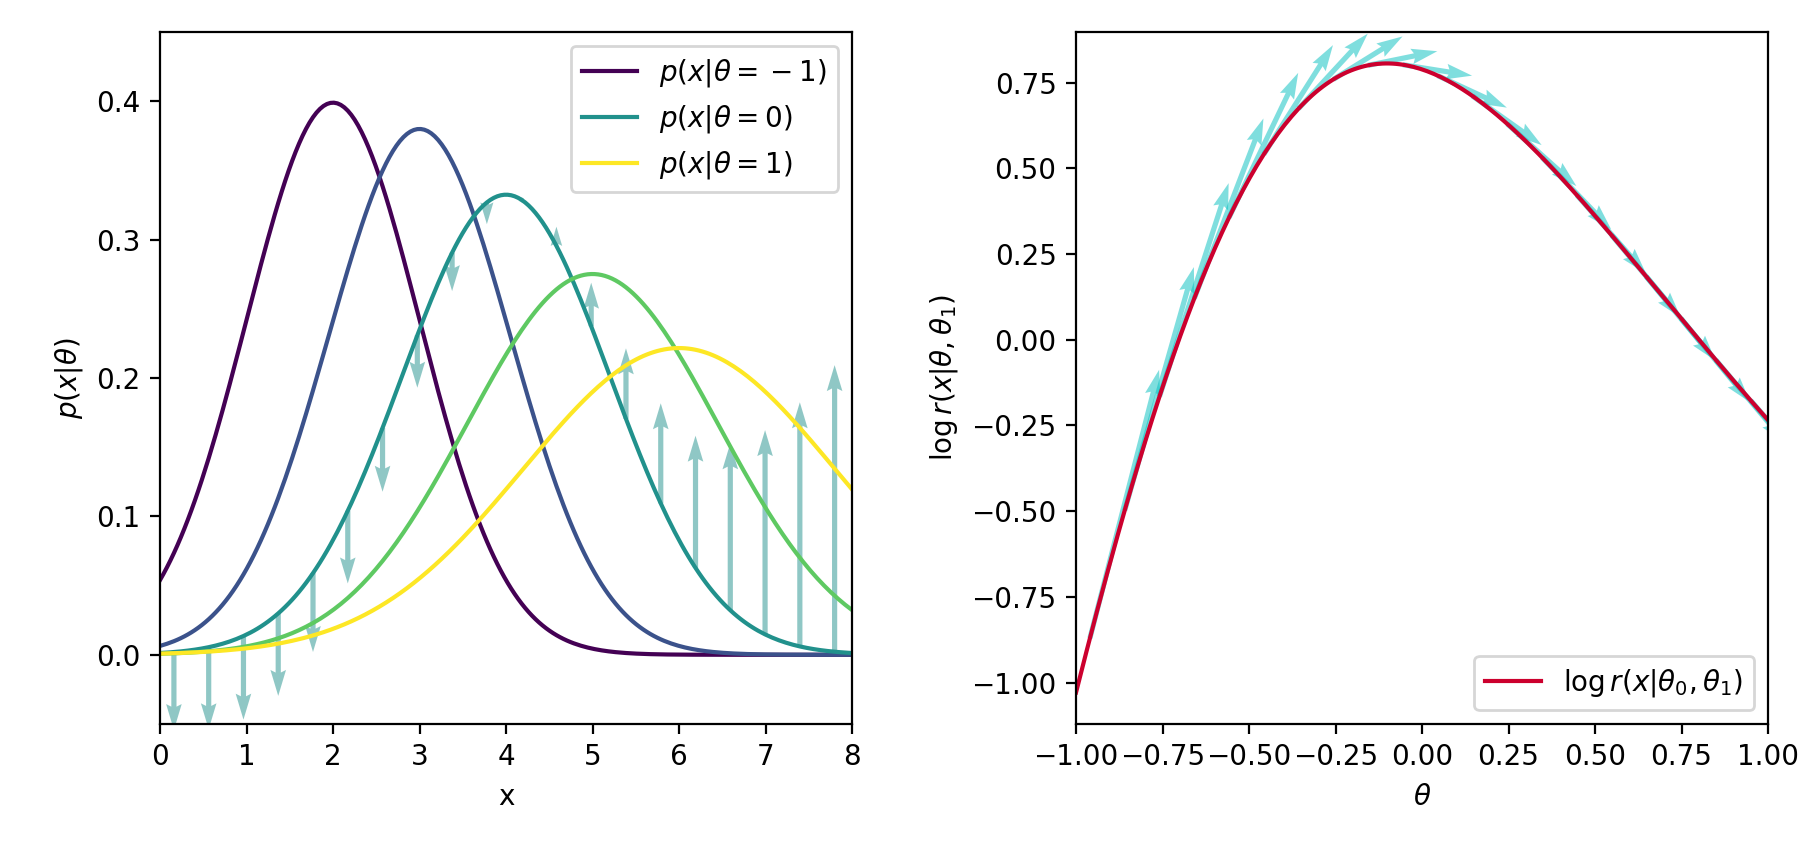

In [361]:
plt.figure(figsize=(9., calculate_height(2,9.)))



plt.subplot(1,2,1)

x = np.linspace(0.,8.,200)
thetas = [-1.,-0.5,0.,0.5,1.]

for i, theta in enumerate(thetas):
    color=ccolor(theta)
    p = pdf(x, theta)
    logp = log_likelihood(x, theta)
    t = score(x, theta)
    
    if i in [0,2,4]:
        plt.plot(x, p, color=color,
                 label= r'$p(x | \theta =' + format_number(theta,0) + ')$')
    else:
        plt.plot(x, p, color=color)
    
    if (i==2):
        plt.quiver(x[i*2::10], p[i*2::10], 0., t[i*2::10], 
                   scale=20,
                   alpha=0.5, color=color)

plt.legend()

plt.xlim(0.,8.)
plt.ylim(-0.05,0.45)
plt.xlabel('x')
plt.ylabel(r'$p(x| \theta)$')



plt.subplot(1,2,2)

thetas = np.linspace(-1.,1.,200)
theta0 = 0.
theta1 = 0.8
x = 4

log_r = np.log(pdf(x, thetas) / pdf(x, theta1))
scores = score(x, thetas)

plt.plot(thetas, log_r, c=colors[0], lw=1.5,
         label=r'$\log\, r(x| \theta_0, \theta_1)$')
plt.quiver(thetas[4::10], log_r[4::10], 1., scores[4::10],
           scale=10,
           alpha=0.5, color=colors[1])

plt.legend(loc='lower right')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log \, r(x|\theta, \theta_1)$')

plt.xlim(-1.,1.)
#plt.ylim(-1.,1.)



adjust_margins(2,9.)
plt.savefig('../figures/illustration/illustration_score.pdf')

<IPython.core.display.Javascript object>


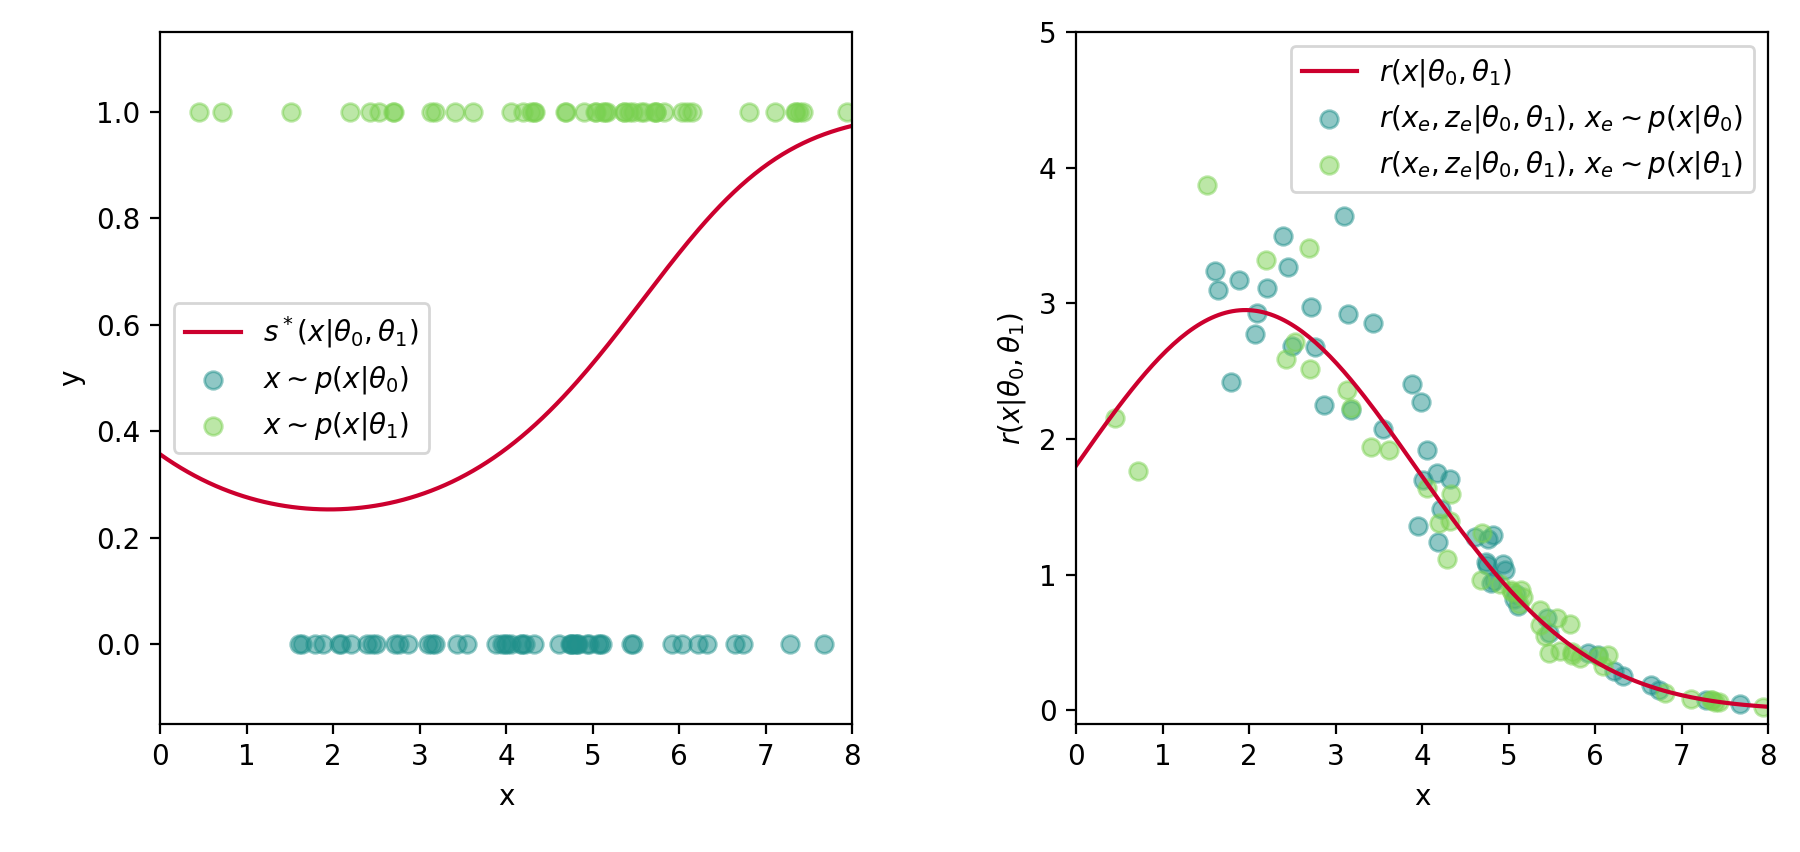

In [324]:
x = np.linspace(0.,8.,200)
theta0 = 0.
theta1 = 0.6

r = pdf(x, theta0) / pdf(x, theta1)
s = s_from_r(r)

x0 = samples(50, theta0)
x1 = samples(50, theta1)

r_x0z = add_noise(pdf(x0, theta0) / pdf(x0, theta1))
r_x1z = add_noise(pdf(x1, theta0) / pdf(x1, theta1))

plt.figure(figsize=(9, calculate_height(2,9)))



plt.subplot(1,2,1)

plt.scatter(x0, np.zeros_like(x0), s=40., c=ccolor(theta0), alpha=0.5,
            label=r'$x \sim p(x | \theta_0)$')
plt.scatter(x1, np.ones_like(x1), s=40., c=ccolor(theta1), alpha=0.5,
            label=r'$x \sim p(x | \theta_1)$')
plt.plot(x, s, c=colors[0], lw=1.5,
         label=r'$s^*(x| \theta_0, \theta_1)$')

plt.legend(loc='center left')

plt.xlabel('x')
plt.ylabel('y')

plt.xlim(0.,8.)
plt.ylim(-0.15,1.15)



plt.subplot(1,2,2)

plt.scatter(x0, r_x0z, s=40., c=ccolor(theta0), alpha=0.5,
            label=r'$r(x_e, z_e| \theta_0, \theta_1)$, $x_e \sim p(x | \theta_0)$')
plt.scatter(x1, r_x1z, s=40., c=ccolor(theta1), alpha=0.5,
            label=r'$r(x_e, z_e| \theta_0, \theta_1)$, $x_e \sim p(x | \theta_1)$')
plt.plot(x, r, c=colors[0], lw=1.5,
         label=r'$r(x| \theta_0, \theta_1)$')

plt.legend(loc='upper right')

plt.xlabel('x')
plt.ylabel(r'$r(x|\theta_0, \theta_1)$')

plt.xlim(0.,8.)
plt.ylim(-0.1,5.)



adjust_margins(2,9.)

plt.savefig('../figures/illustration/illustration_pbp.pdf')

<IPython.core.display.Javascript object>


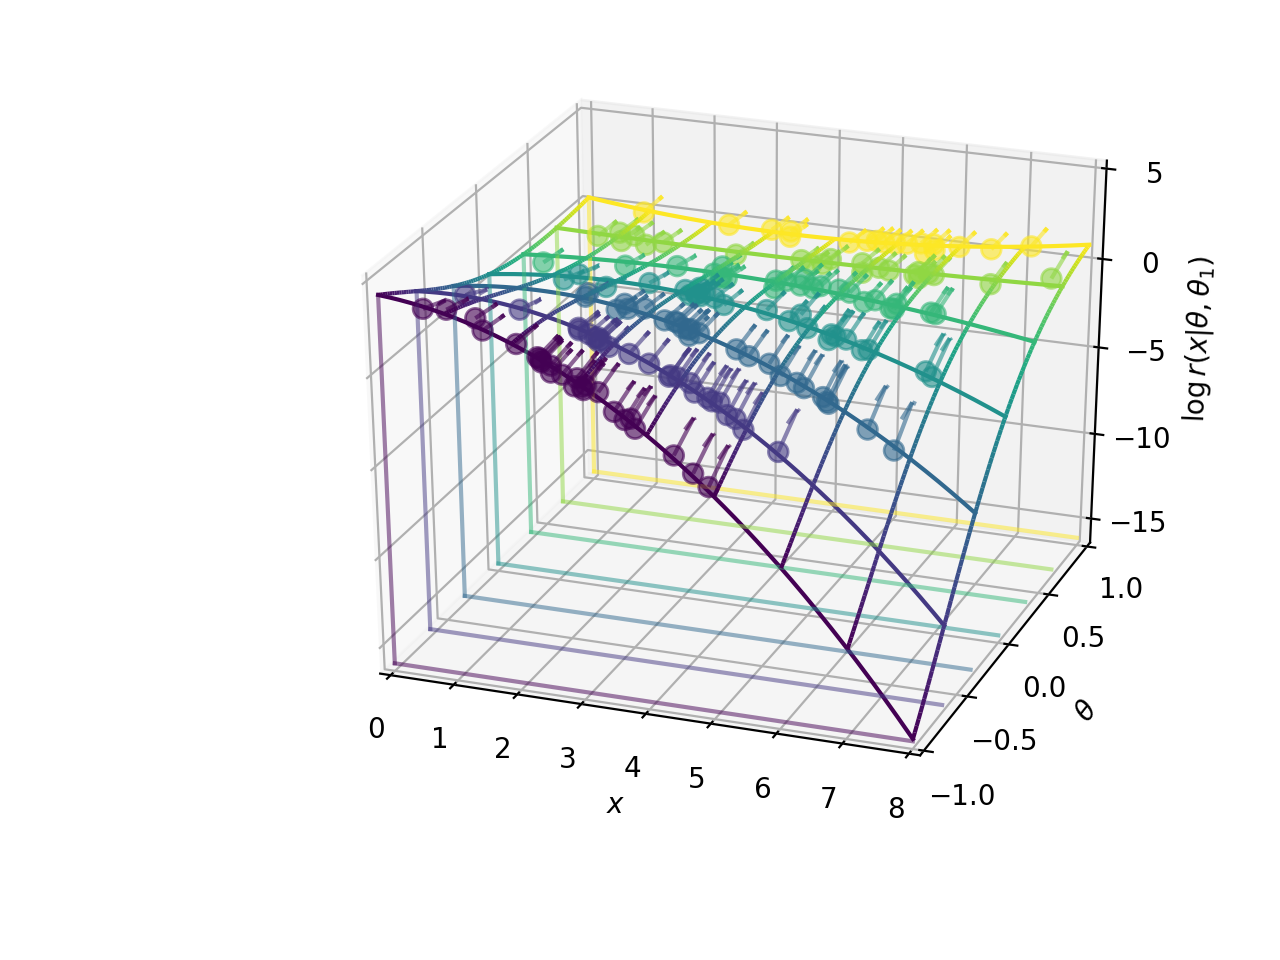

(25,) (25,) (25,)
(24,) (24,) (24,)
(25,) (25,) (25,)
(25,) (25,) (25,)
(24,) (24,) (24,)
(22,) (22,) (22,)
(18,) (18,) (18,)


In [362]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

rmin, rmax = -16.,5.
t = np.linspace(-1.,1.,100)
x = np.linspace(0.,8.,200)
thetas = np.linspace(-1.,1.,7)
xlines = np.linspace(0.,8.,9)
theta1 = 0.6

for theta0 in thetas:
    
    r = np.log(pdf(x, theta0) / pdf(x, theta1))
    x0 = samples(25, theta0)
    x0 = x0[(x0>0.) & (x0<8.)]
    r_x0z = np.log(add_noise(pdf(x0, theta0) / pdf(x0, theta1)))
    scores_x0z = score(x0, theta0)
    
    #x0 = x0[(r_x0z > rmin) & (r_x0z < rmax)]
    #r_x0z = r_x0z[(r_x0z > rmin) & (r_x0z < rmax)]
    #x = x[(r > rmin) & (r < rmax)]
    #r = r[(r > rmin) & (r < rmax)]
    
    _theta0x = np.zeros_like(x)
    _theta0x[:] = theta0
    _theta0s = np.zeros_like(x0)
    _theta0s[:] = theta0
    
    ax.scatter(x0, _theta0s, r_x0z,
               s=50., c=ccolor(theta0), alpha=0.6)
    print(x0.shape,_theta0s.shape,r_x0z.shape,)
    ax.quiver(x0, _theta0s, r_x0z,
              np.zeros_like(scores_x0z), 0.2 * np.ones_like(scores_x0z), 0.2 * scores_x0z,
              normalize=False,
              arrow_length_ratio=0.2,
              color=ccolor(theta0), alpha=0.6)
    ax.plot(x, _theta0x, r,
            c=ccolor(theta0), lw=1.5)
    
    ax.plot([0.,8.], [theta0,theta0], [rmin,rmin],
           c=ccolor(theta0), lw=1.5, alpha=.5)
    ax.plot([0.,0.], [theta0,theta0], [rmin,r[0]],
           c=ccolor(theta0), lw=1.5, alpha=.5)
    
for x in xlines:
    segments = []
    for t_begin, t_end in zip(t[:-1], t[1:]):
        r_begin = np.log(pdf(x, t_begin) / pdf(x, theta1))
        r_end = np.log(pdf(x, t_end) / pdf(x, theta1))
        segments.append( [(x, t_begin, r_begin), (x, t_end, r_end)] )
    segments = np.asarray(segments)

    lc = Line3DCollection(segments, cmap='viridis')
    lc.set_array(t[:-1])
    lc.set_linewidth(1.5)

    ax.add_collection(lc)
    
ax.set_xlim(0.,8.)
ax.set_zlim(rmin, rmax)
ax.set_ylim(-1.,1.)
ax.set_xlabel('$x$')
ax.set_zlabel(r'$\log \, r(x| \theta, \theta_1)$')
ax.set_ylabel(r'$\theta$')
ax.set_xticks([0.,1.,2.,3.,4.,5.,6.,7.,8.])
ax.set_yticks([-1.,-0.5,0.,0.5,1.])
ax.set_zticks([-15.,-10.,-5.,0.,5.])
ax.view_init(elev=28., azim=-70)
    
adjust_margins(1,4.5)
plt.savefig('../figures/illustration/illustration_3d.pdf')

In [354]:
print(ax.elev, ax.azim)

26.3220479286324 -73.21769067796629
